## Обучение модели DETR на рентген-флюорографиях

In [1]:
import csv
from pathlib import Path
from PIL import Image, ImageDraw
from PIL.JpegImagePlugin import JpegImageFile
import numpy as np
import io
from datasets import Dataset
import albumentations as A
from transformers import AutoImageProcessor, AutoModelForObjectDetection, TrainingArguments, Trainer, pipeline
import torch
import wandb
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torch.nn.functional import softmax

/home/neuro/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path_dataset = r'/home/neuro/tuberculosis_dataset/'
bbox_filename = r'bbox.csv'

In [3]:
label2id = {'no_tb': 0, 'tb': 1}

In [4]:
import os

path = r'/home/neuro/tuberculosis_dataset/my_bbox.csv'

if os.path.exists(path):
    print('Файл существует')
else:
    print('Файл не найден')

Файл существует


In [5]:
import pandas as pd

df = pd.read_csv('/home/neuro/tuberculosis_dataset/bbox.csv')

display(df)

bbox_id      fname  image_height  image_width source  bbox target  \
0           0  h4519.png           512          512  train  none  no_tb   
1           1  h2665.png           512          512    val  none  no_tb   
2           2  h2828.png           512          512  train  none  no_tb   
3           3  h2208.png           512          512  train  none  no_tb   
4           4  h4246.png           512          512    val  none  no_tb   
...       ...        ...           ...          ...    ...   ...    ...   
8394     8394  h4602.png           512          512  train  none  no_tb   
8395     8395  h1990.png           512          512  train  none  no_tb   
8396     8396  h0057.png           512          512   test  none  no_tb   
8397     8397  h3529.png           512          512  train  none  no_tb   
8398     8398  s3961.png           512          512  train  none  no_tb   

     tb_type      image_type  
0       none         healthy  
1       none         healthy  
2       none         healthy  
3       none         healthy  
4       none         healthy  
...      ...             ...  
8394    none         healthy  
8395    none         healthy  
8396    none         healthy  
8397    none         healthy  
8398    none  sick_but_no_tb  

[8399 rows x 9 columns]

In [6]:
import csv


with open(f"{path_dataset}{bbox_filename}", "r", encoding="utf-8") as file:
    reader = csv.DictReader(file)
    print(reader.fieldnames)  

['bbox_id', 'fname', 'image_height', 'image_width', 'source', 'bbox', 'target', 'tb_type', 'image_type']


In [7]:
def load_img_to_bbox(path_dataset, bbox_filename):

    dataset = {'train': {}, 'val': {}, 'test': {}}

    with open(f"{path_dataset}{bbox_filename}", "r", encoding="utf-8") as file:

        reader = csv.DictReader(file)
        for row in reader:

            if row['fname'] not in dataset[row['source']]:
                dataset[row['source']][row['fname']] = {'bbox_id': [], 'category': [], 'bbox': [], 'area': []}

            dataset[row['source']][row['fname']]['bbox_id'].append(int(row['bbox_id']))
            dataset[row['source']][row['fname']]['category'].append(label2id[row['target']])

            bbox = []
            area = 0

            if row['target'] == 'tb':

                dict_bbox = eval(row['bbox'])

                xmin, ymin = dict_bbox['xmin'], dict_bbox['ymin']
                xmax, ymax = dict_bbox['xmin'] + dict_bbox['width'], dict_bbox['ymin'] + dict_bbox['height']

                bbox = [xmin, ymin, xmax, ymax]
                area = (xmax - xmin) * (ymax - ymin)

            else:

                bbox = [0.0, 0.0, 2.0, 2.0]
                area = float(row['image_width']) * float(row['image_height'])

            dataset[row['source']][row['fname']]['bbox'].append(bbox)
            dataset[row['source']][row['fname']]['area'].append(area)

    return dataset['train'], dataset['val'], dataset['test']


train_img_to_bbox, val_img_to_bbox, test_img_to_bbox = load_img_to_bbox(path_dataset=path_dataset, bbox_filename=bbox_filename)


In [8]:
img_to_ids = dict()
i = 0

for img in train_img_to_bbox.keys():
    i += 1
    img_to_ids[img] = i

for img in val_img_to_bbox.keys():
    i += 1
    img_to_ids[img] = i

for img in test_img_to_bbox.keys():
    i += 1
    img_to_ids[img] = i

In [9]:
id2label = {id: label for label, id in label2id.items()}

In [10]:
def pathToJpeg(image_path):

    png_image = Image.open(image_path)
    jpeg_image = png_image.convert("RGB")
    buffer = io.BytesIO()
    jpeg_image.save(buffer, format="JPEG")
    buffer.seek(0)
    return Image.open(buffer)

In [11]:
def load_dataset(img_to_bbox, img_to_ids, path_to_images):

    dataset = []

    for image_name in img_to_bbox.keys():

        image_id = img_to_ids[image_name]

        img_path = f'{path_to_images}{image_name}'
        image = pathToJpeg(img_path)

        width, height = image.size

        dataset.append(
            {
                'image_id': image_id,
                'image': image,
                'width': width,
                'height': height,
                'objects': img_to_bbox[image_name]
            }
        )

    return dataset


train_dataset = load_dataset(img_to_bbox=train_img_to_bbox, img_to_ids=img_to_ids, path_to_images=f'{path_dataset}/train/')
test_dataset = load_dataset(img_to_bbox=test_img_to_bbox, img_to_ids=img_to_ids, path_to_images=f'{path_dataset}/test/')
val_dataset = load_dataset(img_to_bbox=val_img_to_bbox, img_to_ids=img_to_ids, path_to_images=f'{path_dataset}/val/')

In [12]:
train_dataset = Dataset.from_list(train_dataset)
val_dataset = Dataset.from_list(val_dataset)
test_dataset = Dataset.from_list(test_dataset)

In [13]:
id_list = []
category_examples = {}
for example in train_dataset:
  id_list += example['objects']['bbox_id']
  for category in example['objects']['category']:
    if id2label[category] not in category_examples:
      category_examples[id2label[category]] = 1
    else:
      category_examples[id2label[category]] += 1

id_list.sort()

In [14]:
train_transform = A.Compose(
    [
        # Масштабирует изображение так, чтобы его самая длинная сторона была не более 500 пикселей
        A.LongestMaxSize(500),
        # Дополняет изображение до размеров 500x500, если его размеры меньше, добавляя чёрную рамку (цвет (0, 0, 0))
        # Параметр border_mode=0 указывает использовать цветовую заливку
        A.PadIfNeeded(500, 500, border_mode=0, value=(0, 0, 0)),
        # С вероятностью 50% (p=0.5) отражает изображение по горизонтали
        A.HorizontalFlip(p=0.5),
        # С вероятностью 50% случайно масштабирует изображение в пределах от 80% до 120% от его первоначального размера
        A.RandomScale(scale_limit=0.2, p=0.5),
    ],
    bbox_params=A.BboxParams(
        # указывает формат прямоугольников (широко используется формат Pascal VOC,
        # где bbox задается как [x_min, y_min, x_max, y_max])
        format="pascal_voc",
        # передает список меток объектов, чтобы аугментации применялись синхронно к объектам и меткам категорий
        label_fields=["category"]
    ),
)

val_transform = A.Compose(
    [
        A.LongestMaxSize(500),
        A.PadIfNeeded(500, 500, border_mode=0, value=(0, 0, 0)),
    ],
    bbox_params=A.BboxParams(
        format="pascal_voc",
        label_fields=["category"]
    ),
)

In [15]:
checkpoint = "facebook/detr-resnet-50-dc5"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [16]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations


def convert_voc_to_coco(bbox):
    xmin, ymin, xmax, ymax = bbox
    width = xmax - xmin
    height = ymax - ymin
    return [xmin, ymin, width, height]


def transform_aug_ann(examples, transform):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])

        # Convert to COCO format
        converted_bboxes = [convert_voc_to_coco(bbox) for bbox in out["bboxes"]]
        bboxes.append(converted_bboxes)

        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

def transform_train(examples):
    return transform_aug_ann(examples, transform=train_transform)

def transform_val(examples):
    return transform_aug_ann(examples, transform=val_transform)

train_dataset_transformed = train_dataset.with_transform(transform_train)
val_dataset_transformed = val_dataset.with_transform(transform_val)
test_dataset_transformed = test_dataset.with_transform(transform_val)

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [18]:
model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
).to(device)

Some weights of the model checkpoint at facebook/detr-resnet-50-dc5 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model check

In [19]:
output_dir = "./model/"

In [20]:
training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    max_steps=100000,
    fp16=True,
    save_steps=1000,
    logging_steps=1000,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    evaluation_strategy="steps",
    eval_steps=500,
    eval_strategy = "steps",
    batch_eval_metrics=True,
)

/home/neuro/myenv/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [21]:
def denormalize_boxes(boxes, width, height):
    boxes = boxes.clone()
    boxes[:, 0] *= width  # xmin
    boxes[:, 1] *= height  # ymin
    boxes[:, 2] *= width  # xmax
    boxes[:, 3] *= height  # ymax
    return boxes

batch_metrics = []
def compute_metrics(eval_pred, compute_result):
    global batch_metrics

    (loss_dict, scores, pred_boxes, last_hidden_state, encoder_last_hidden_state), labels = eval_pred

    image_sizes = []
    target = []
    for label in labels:
        width, height = ([500, 500] if len(label['orig_size']) != 2 else label['orig_size'])
        image_sizes.append([width, height])
        denormalized_boxes = denormalize_boxes(label["boxes"], width, height)
        target.append(
            {
                "boxes": denormalized_boxes,
                "labels": label["class_labels"],
            }
        )
    predictions = []
    for score, box, target_sizes in zip(scores, pred_boxes, image_sizes):
        # Extract the bounding boxes, labels, and scores from the model's output
        pred_scores = score[:, :-1]  # Exclude the no-object class
        pred_scores = softmax(pred_scores, dim=-1)
        width, height = target_sizes
        pred_boxes = denormalize_boxes(box, width, height)
        pred_labels = torch.argmax(pred_scores, dim=-1)

        # Get the scores corresponding to the predicted labels
        pred_scores_for_labels = torch.gather(pred_scores, 1, pred_labels.unsqueeze(-1)).squeeze(-1)
        predictions.append(
            {
                "boxes": pred_boxes,
                "scores": pred_scores_for_labels,
                "labels": pred_labels,
            }
        )

    metric = MeanAveragePrecision(box_format='xywh', class_metrics=True)

    if not compute_result:
        # Accumulate batch-level metrics
        batch_metrics.append({"preds": predictions, "target": target})
        return {}
    else:
        # Compute final aggregated metrics
        # Aggregate batch-level metrics (this should be done based on your metric library's needs)
        all_preds = []
        all_targets = []
        for batch in batch_metrics:
            all_preds.extend(batch["preds"])
            all_targets.extend(batch["target"])

        # Update metric with all accumulated predictions and targets
        metric.update(preds=all_preds, target=all_targets)
        metrics = metric.compute()

        # Convert and format metrics as needed
        classes = metrics.pop("classes")
        map_per_class = metrics.pop("map_per_class")
        mar_100_per_class = metrics.pop("mar_100_per_class")

        for class_id, class_map, class_mar in zip(classes, map_per_class, mar_100_per_class):
            class_name = id2label[class_id.item()] if id2label is not None else class_id.item()
            metrics[f"map_{class_name}"] = class_map
            metrics[f"mar_100_{class_name}"] = class_mar

        # Round metrics for cleaner output
        metrics = {k: round(v.item(), 4) for k, v in metrics.items()}

        # Clear batch metrics for next evaluation
        batch_metrics = []

        return metrics

In [22]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]

    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels

    return batch

In [23]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=train_dataset_transformed,
    eval_dataset=test_dataset_transformed,
    tokenizer=image_processor,
    compute_metrics=compute_metrics
)

/tmp/ipykernel_957307/1024624663.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [24]:
# trainer.train()
# trainer.save_model(output_dir)

In [25]:
obj_detector = pipeline(
    "object-detection", model=output_dir)

Device set to use cuda:0


In [26]:
# Старая версия функции
def calculate_iou_(predict_bbox, true_bbox):

    x1_pred, y1_pred, x2_pred, y2_pred = predict_bbox
    x1_true, y1_true, x2_true, y2_true = true_bbox
    
    x1_inter = max(x1_pred, x1_true)
    y1_inter = max(y1_pred, y1_true)
    x2_inter = min(x2_pred, x2_true)
    y2_inter = min(y2_pred, y2_true)
    
    inter_width = max(0, x2_inter - x1_inter)
    inter_height = max(0, y2_inter - y1_inter)
    inter_area = inter_width * inter_height
    
    pred_area = (x2_pred - x1_pred) * (y2_pred - y1_pred)
    true_area = (x2_true - x1_true) * (y2_true - y1_true)
    
    union_area = pred_area + true_area - inter_area
    iou = inter_area / union_area if union_area != 0 else 0
    
    return iou

In [27]:
def calculate_iou(boxA, boxB):

    # determine the (x, y)-coordinates of the intersection rectangle
  xA = max(boxA[0], boxB[0])
  yA = max(boxA[1], boxB[1])
  xB = min(boxA[2], boxB[2])
  yB = min(boxA[3], boxB[3])
  # compute the area of intersection rectangle
  interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
  # compute the area of both the prediction and ground-truth
  # rectangles
  boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
  boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
  # compute the intersection over union by taking the intersection
  # area and dividing it by the sum of prediction + ground-truth
  # areas - the interesection area
  iou = interArea / float(boxAArea + boxBArea - interArea)
  # return the intersection over union value
  return iou

In [28]:
def select_best_bbox(predicted_bboxes):

    if not predicted_bboxes:
        return None
    
    best_bbox = max(predicted_bboxes, key=lambda bbox: bbox['score'])
    return best_bbox

In [29]:
# Вычисление IoU без скипов

def evaluate_model(test_data, obj_detector):
    total_true_positives = 0
    total_true_negatives = 0
    total_false_positives = 0
    total_false_negatives = 0

    total_iou = 0
    count = 0

    for sample in test_data:
        true_bbox = sample['objects']['bbox'][0]  
        image_data = sample['image']             

        predicted_bboxes = obj_detector(image_data)
        best_prediction = select_best_bbox(predicted_bboxes)
        
        if best_prediction:

            predicted_bbox = [
                best_prediction['box']['xmin'],
                best_prediction['box']['ymin'],
                best_prediction['box']['xmax'],
                best_prediction['box']['ymax']
            ]
            iou = calculate_iou(predicted_bbox, true_bbox)
            total_iou += iou
        else:

            best_prediction = {'label': 'no_tb'}

        true_label = id2label[sample['objects']['category'][0]]  
        predicted_label = best_prediction['label']

        if predicted_label == true_label:
            if predicted_label == 'no_tb':
                total_true_negatives += 1
            else:
                total_true_positives += 1
        else:
            if predicted_label == 'no_tb':
                total_false_negatives += 1
            else:
                total_false_positives += 1

        count += 1

    recall = total_true_positives / (total_true_positives + total_false_negatives) if (total_true_positives + total_false_negatives) > 0 else 0
    precision = total_true_positives / (total_true_positives + total_false_positives) if (total_true_positives + total_false_positives) > 0 else 0
    average_iou = total_iou / count if count > 0 else 0

    return {
        'IoU': average_iou,
        'Recall': recall,
        'Precision': precision
    }
    
evaluate_model(test_data=test_dataset, obj_detector=obj_detector)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


{'IoU': 0.02468267961230247,
 'Recall': 0.8043478260869565,
 'Precision': 0.9736842105263158}

In [30]:
# Тут функция скипает случаи, когда таргет "здоров"

def evaluate_model(test_data, obj_detector):
    total_true_positives = 0
    total_true_negatives = 0
    total_false_positives = 0
    total_false_negatives = 0
    
    total_iou = 0
    count = 0
    count_with_disease = 0  

    for sample in test_data:
        true_bbox = sample['objects']['bbox'][0]
        image_data = sample['image']

        if true_bbox == [0.0, 0.0, 2.0, 2.0]:
            continue

        predicted_bboxes = obj_detector(image_data)
        best_prediction = select_best_bbox(predicted_bboxes)

        if best_prediction:
            predicted_bbox = [
                best_prediction['box']['xmin'],
                best_prediction['box']['ymin'],
                best_prediction['box']['xmax'],
                best_prediction['box']['ymax'],
            ]
            iou = calculate_iou(predicted_bbox, true_bbox)
            total_iou += iou
            count_with_disease += 1  
            
        else:
            best_prediction = {'label': 'no_tb'}
        
        true_label = id2label[sample['objects']['category'][0]]
        predicted_label = best_prediction['label']

        if predicted_label == true_label:
            if predicted_label == 'no_tb':
                total_true_negatives += 1
            else:
                total_true_positives += 1
        else:
            if predicted_label == 'no_tb':
                total_false_negatives += 1
            else:
                total_false_positives += 1

        count += 1

    recall = total_true_positives / (total_true_positives + total_false_negatives) if (total_true_positives + total_false_negatives) > 0 else 0
    precision = total_true_positives / (total_true_positives + total_false_positives) if (total_true_positives + total_false_positives) > 0 else 0
    average_iou = total_iou / count_with_disease if count_with_disease > 0 else 0

    return {
        'IoU': average_iou,
        'Recall': recall,
        'Precision': precision
    }
    
evaluate_model(test_data=test_dataset, obj_detector=obj_detector)

{'IoU': 0.4539466728697368, 'Recall': 0.8043478260869565, 'Precision': 1.0}

In [31]:
# Тут функция скипает случаи, когда или таргет, или предикт "здоров"

def evaluate_model(test_data, obj_detector):
    total_true_positives = 0
    total_false_positives = 0
    total_false_negatives = 0

    total_iou = 0
    count_valid_cases = 0

    for sample in test_data:
        true_bbox = sample['objects']['bbox'][0]
        image_data = sample['image']

        true_label = id2label[sample['objects']['category'][0]]

        predicted_bboxes = obj_detector(image_data)
        best_prediction = select_best_bbox(predicted_bboxes)

        if best_prediction:
            predicted_label = best_prediction['label']
            predicted_bbox = [
                best_prediction['box']['xmin'],
                best_prediction['box']['ymin'],
                best_prediction['box']['xmax'],
                best_prediction['box']['ymax'],
            ]
        else:
            predicted_label = 'no_tb'
            predicted_bbox = [0, 0, 2, 2]

        if true_label == 'no_tb' or predicted_label == 'no_tb':
            continue

        iou = calculate_iou(predicted_bbox, true_bbox)
        total_iou += iou
        count_valid_cases += 1

        if predicted_label == true_label:
            total_true_positives += 1
        else:
            total_false_positives += 1
            total_false_negatives += 1

    recall = total_true_positives / (total_true_positives + total_false_negatives) if (total_true_positives + total_false_negatives) > 0 else 0
    precision = total_true_positives / (total_true_positives + total_false_positives) if (total_true_positives + total_false_positives) > 0 else 0
    average_iou = total_iou / count_valid_cases if count_valid_cases > 0 else 0

    return {
        'IoU': average_iou,
        'Recall': recall,
        'Precision': precision
    }

In [32]:
evaluate_model(test_data=test_dataset, obj_detector=obj_detector)

{'IoU': 0.5643661338380511, 'Recall': 1.0, 'Precision': 1.0}

In [33]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_bbox(image, true_bbox, predicted_bbox):
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    rect_true = patches.Rectangle(
        (true_bbox[0], true_bbox[1]), 
        true_bbox[2] - true_bbox[0], 
        true_bbox[3] - true_bbox[1],
        linewidth=2, edgecolor='g', facecolor='none'
    )
    ax.add_patch(rect_true)

    rect_pred = patches.Rectangle(
        (predicted_bbox[0], predicted_bbox[1]), 
        predicted_bbox[2] - predicted_bbox[0], 
        predicted_bbox[3] - predicted_bbox[1],
        linewidth=2, edgecolor='r', facecolor='none'
    )
    ax.add_patch(rect_pred)

    plt.show()

In [45]:
# Фильтруем тестовый датасет, исключая изображения с фиктивной рамкой [0, 0, 2, 2]

disease_test_dataset = [
    sample for sample in test_dataset 
    if not (len(sample['objects']['bbox']) == 1 and sample['objects']['bbox'][0] == [0.0, 0.0, 2.0, 2.0])
]

print(f"Количество изображений с реальной болезнью: {len(disease_test_dataset)}")

Количество изображений с реальной болезнью: 46


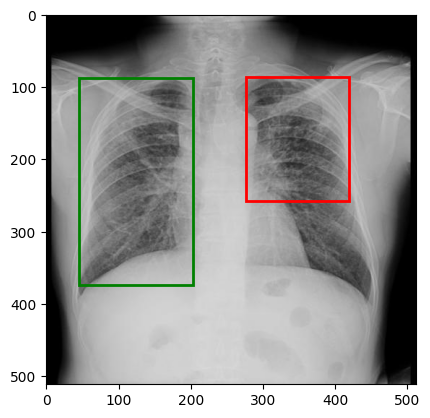

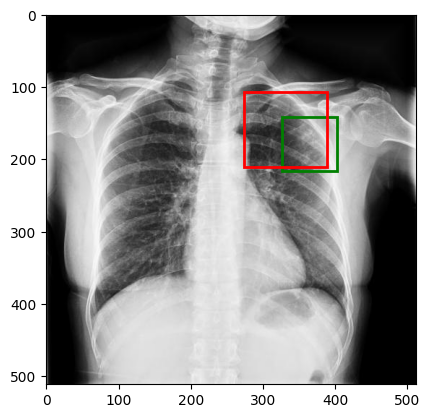

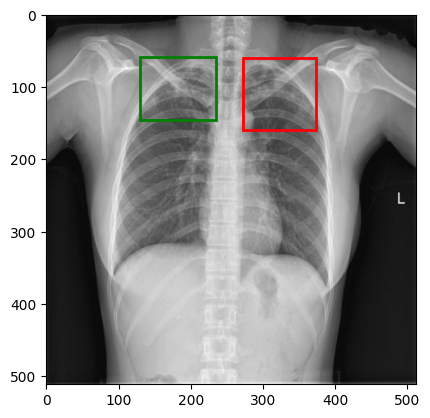

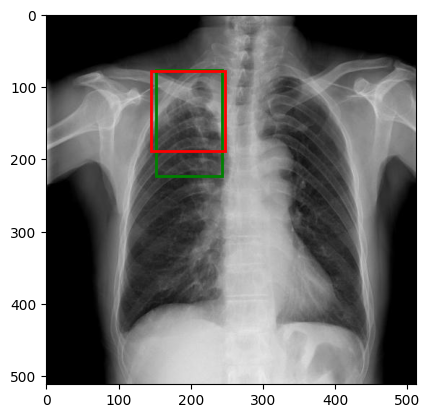

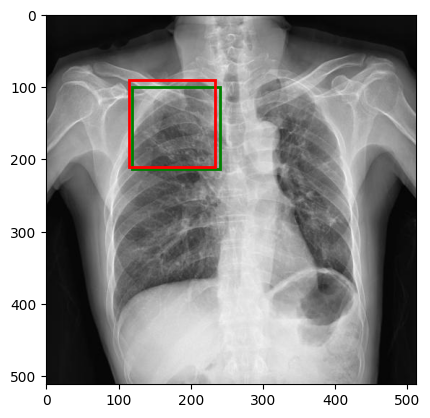

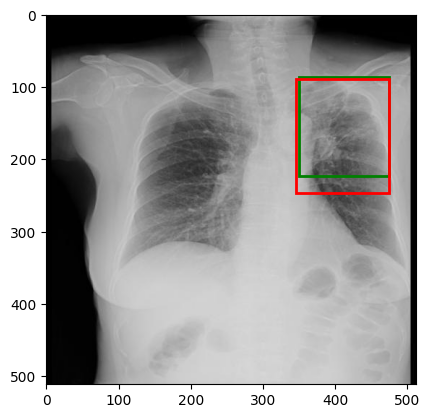

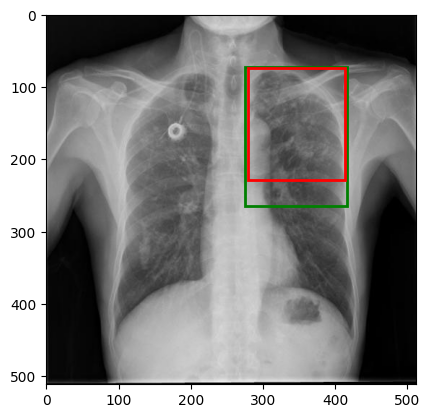

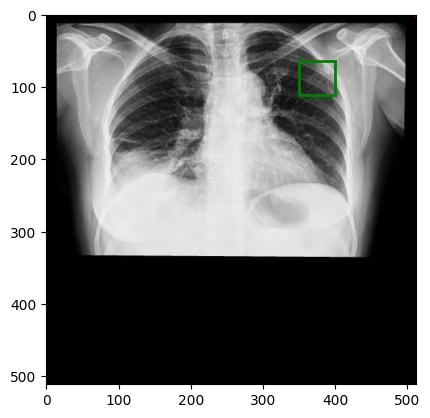

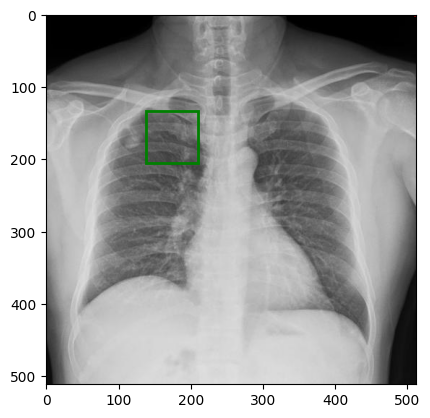

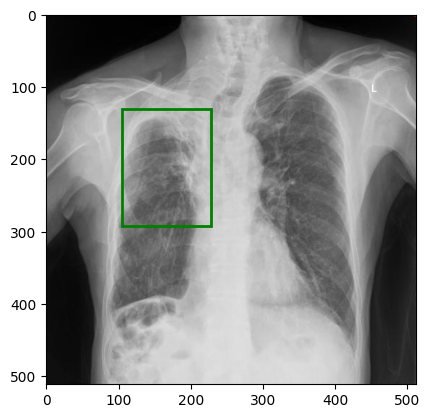

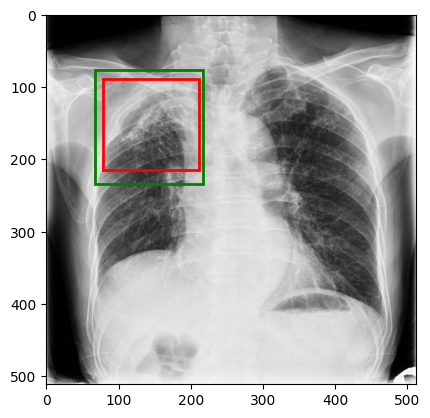

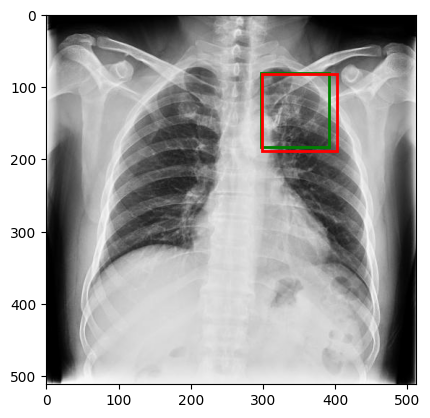

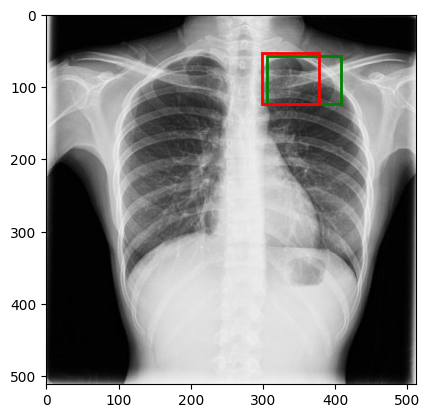

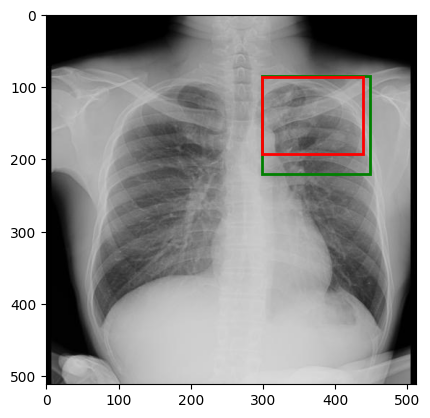

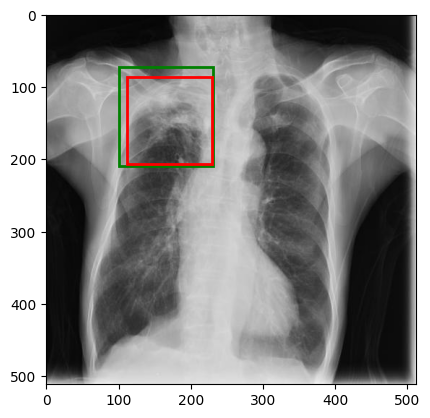

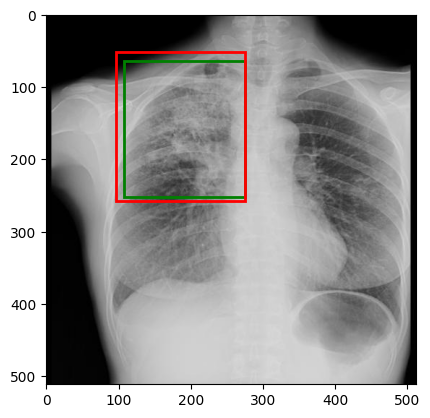

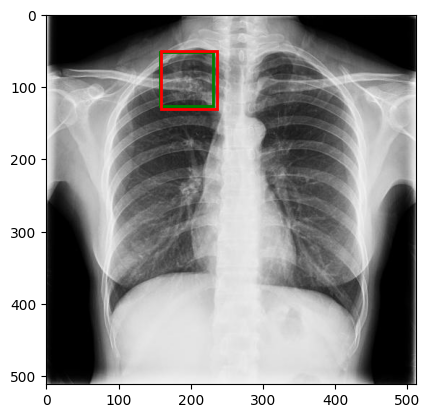

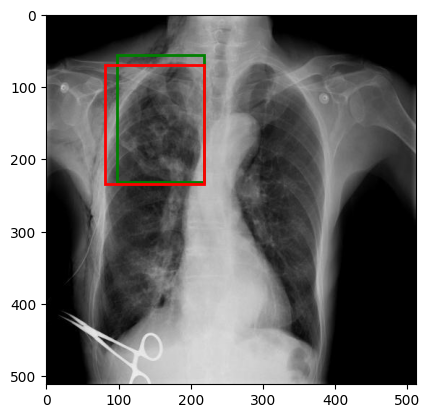

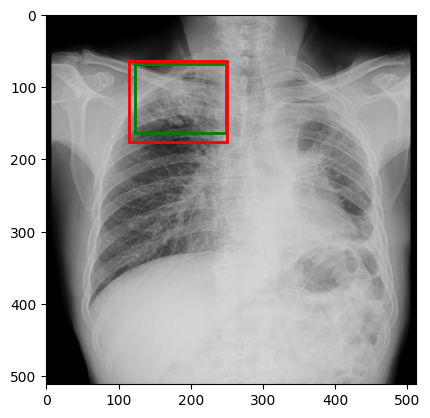

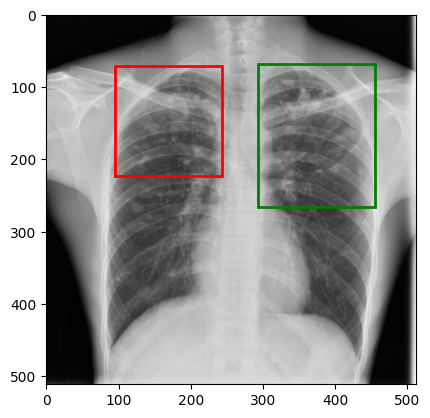

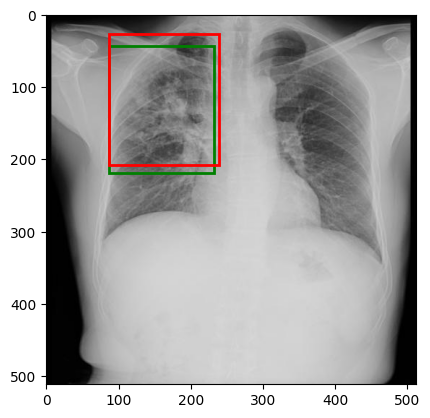

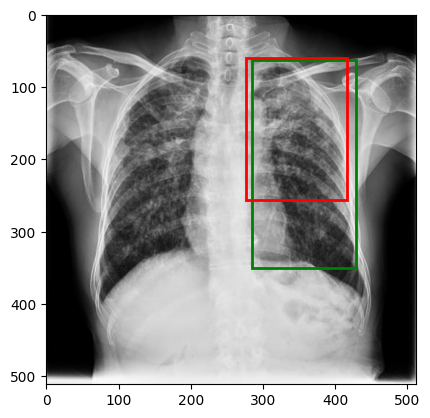

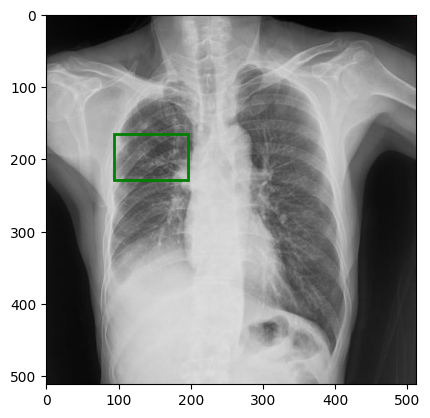

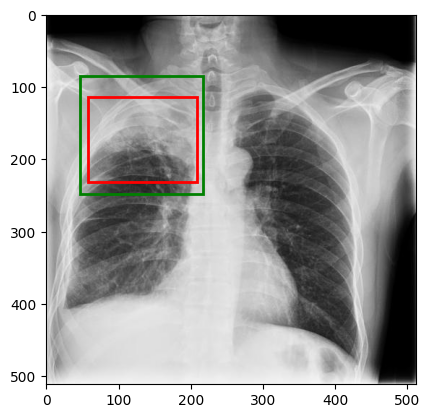

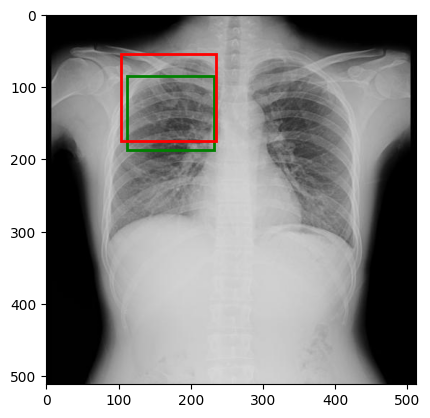

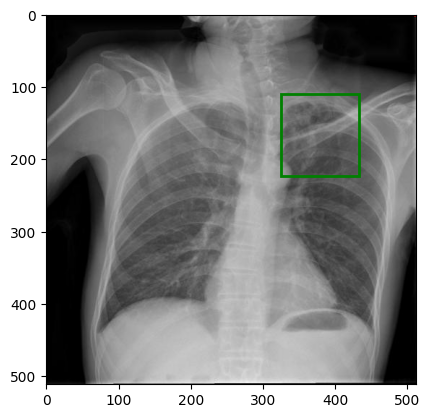

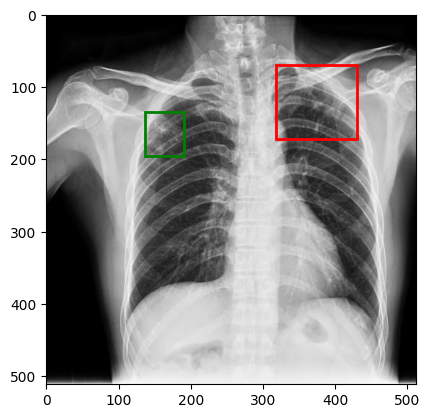

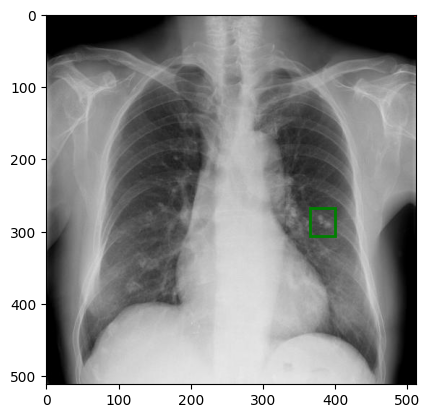

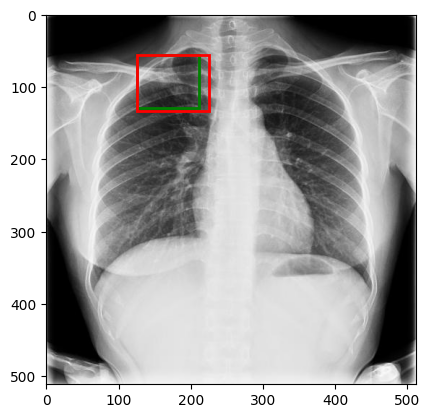

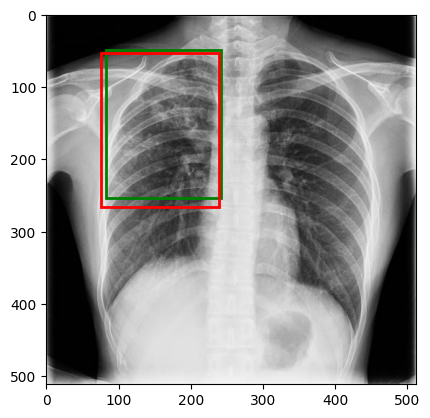

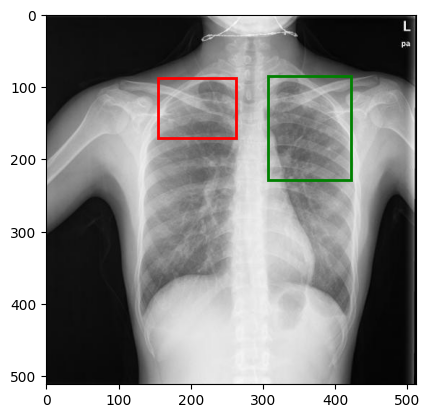

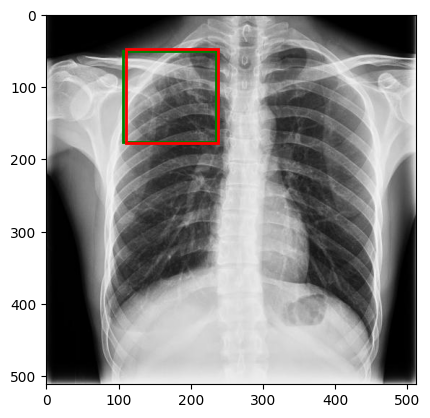

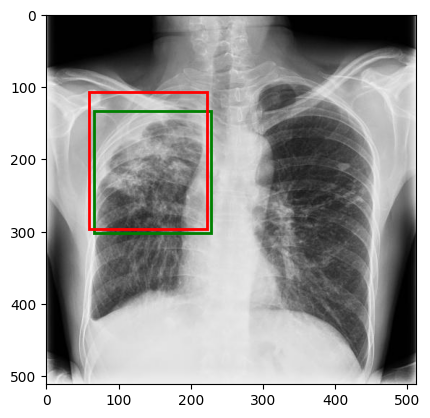

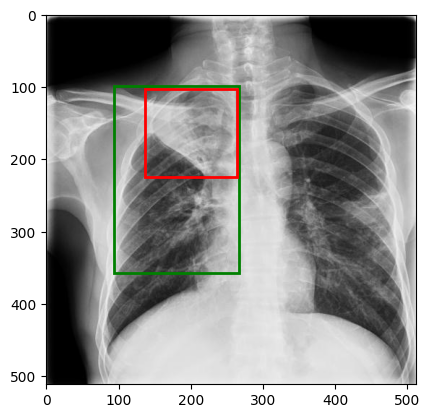

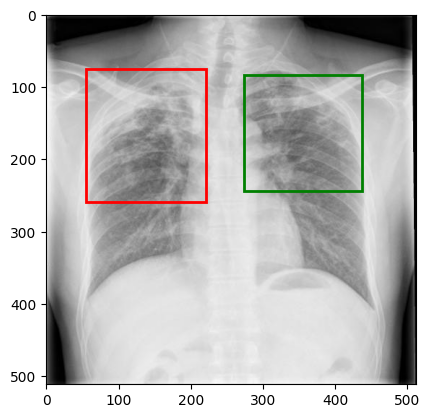

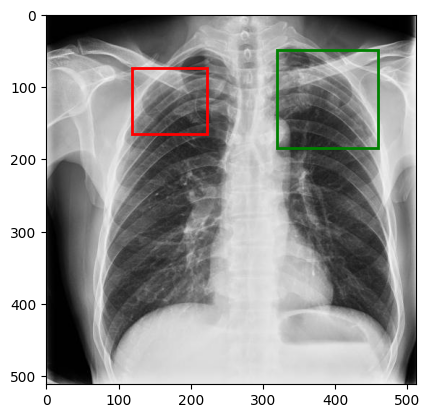

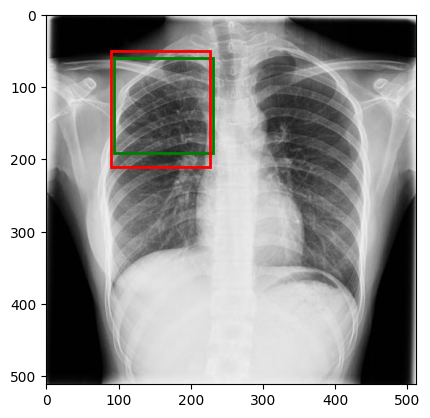

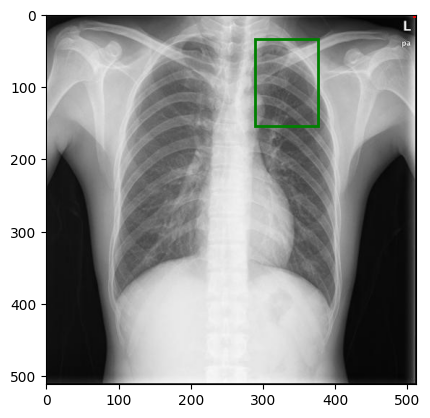

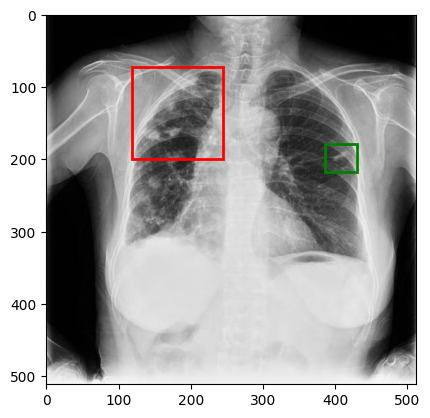

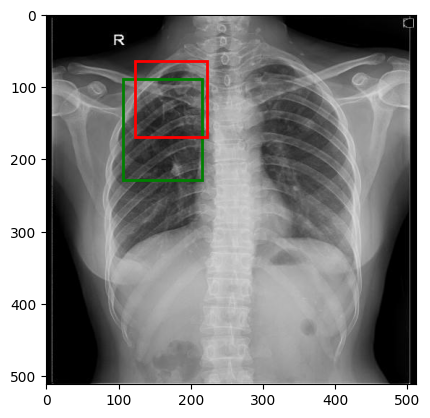

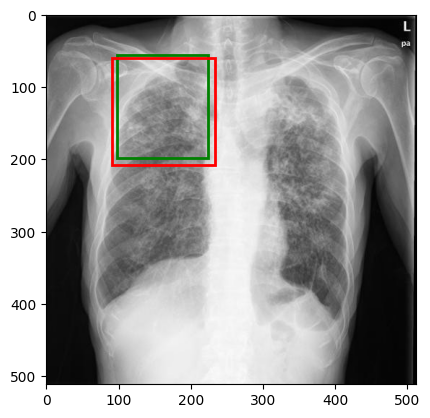

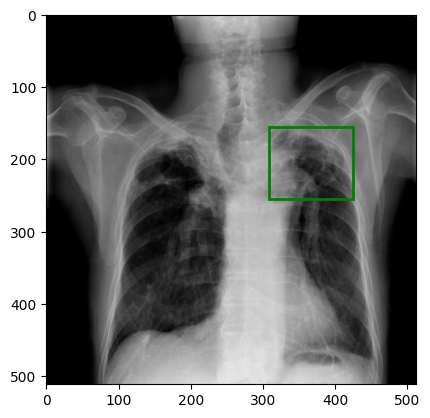

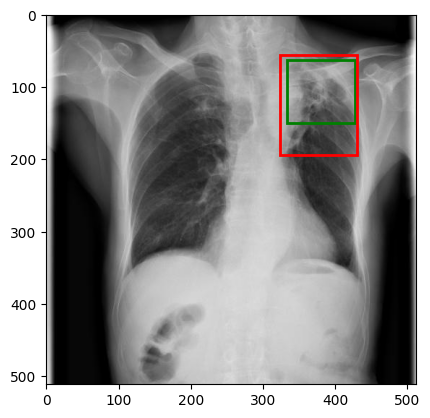

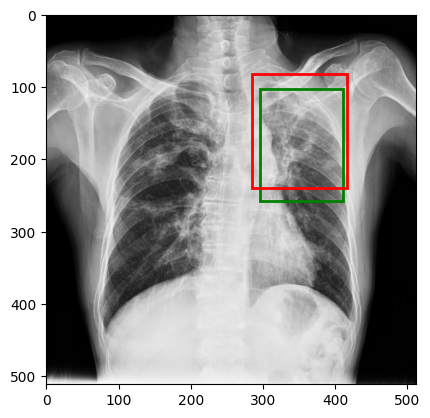

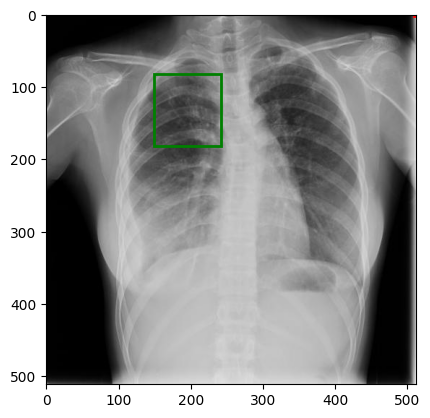

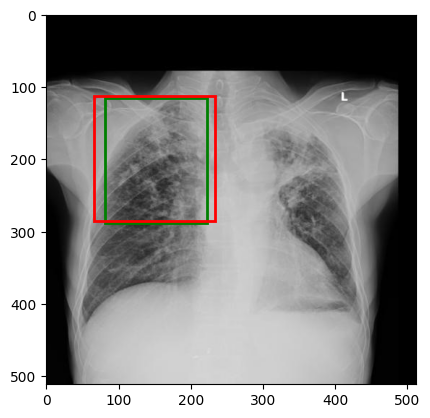

In [46]:
for sample in disease_test_dataset:
    image = sample['image']
    true_bbox = sample['objects']['bbox'][0] 
    
    predicted_bboxes = obj_detector(image)
    best_prediction = select_best_bbox(predicted_bboxes)
    
    if best_prediction:
        predicted_bbox = [
            best_prediction['box']['xmin'],
            best_prediction['box']['ymin'],
            best_prediction['box']['xmax'],
            best_prediction['box']['ymax']
        ]
    else:
        predicted_bbox = [0.0, 0.0, 2.0, 2.0]

    # Визуализация рамок
    visualize_bbox(image, true_bbox, predicted_bbox)